In [109]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#Import module from folder in another directory
import importlib.util
spec = importlib.util.spec_from_file_location("outliers", "data_preprocessing/outliers.py")
outliers = importlib.util.module_from_spec(spec)
spec.loader.exec_module(outliers)

import warnings
warnings.filterwarnings("ignore")

from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestRegressor
%matplotlib inline

In [74]:
train_data = pd.read_csv('../data/input/train.csv')
test_data = pd.read_csv('../data/input/test.csv')

In [75]:
targetValue = train_data[train_data.columns.values[-1]]
targetValueLog = np.log(targetValue)

Append test data in train data once to check ranges and missing values

In [76]:
train_data = train_data[train_data.columns.values[:-1]]
combinedData = train_data.append(test_data, ignore_index=True)
combinedData.shape, train_data.shape, test_data.shape

((2919, 80), (1460, 80), (1459, 80))

Separate Categorical and Numerical Data for different handling

In [77]:
#TODO - Probably create a module for the separation of Cat and Num data

categoricalData = []

for data in combinedData.columns.values:
    if combinedData[data].dtype == 'object':
        categoricalData.append(data)
        
numericalData = combinedData.drop(categoricalData,axis=1)
categoricalData = combinedData[categoricalData]

In [78]:
numericalData = outliers.outlier_removal_cont_data(numericalData)

In [79]:
numericalData.head()

,Id,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,1,60,8450,7,5,2003,2003,0.0,0.023500,0.0,...,0.019812,0,61,0,0,0,0,0,2,2008
1,2,20,9600,6,8,1976,1976,0.0,0.024668,0.0,...,0.016631,298,0,0,0,0,0,0,5,2007
2,3,60,11250,7,5,2001,2002,0.0,0.022162,0.0,...,0.021981,0,42,0,0,0,0,0,9,2008
3,4,70,9550,7,5,1915,1970,0.0,0.019257,0.0,...,0.023211,0,35,272,0,0,0,0,2,2006
4,5,60,14260,8,5,2000,2000,0.0,0.023232,0.0,...,0.030224,192,84,0,0,0,0,0,12,2008


In [80]:
categoricalData = outliers.outlier_removal_cat_data(categoricalData)

In [81]:
categoricalData.head()

,MSZoning_0,MSZoning_1,MSZoning_2,MSZoning_3,MSZoning_4,Street_0,LotShape_0,LotShape_1,LotShape_2,LandContour_0,...,SaleType_4,SaleType_5,SaleType_6,SaleType_7,SaleType_8,SaleCondition_0,SaleCondition_1,SaleCondition_2,SaleCondition_3,SaleCondition_4
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1


Merging numerical and categorical data back together

In [82]:
combinedData = numericalData.join(categoricalData)

train_data = combinedData.iloc[:len(train_data)-1]
train_data = train_data.join(targetValueLog)

test_data = combinedData.iloc[len(train_data)+1:]

trainX = train_data[train_data.columns.values[1:-1]]
trainY = train_data[train_data.columns.values[-1]]

testX = test_data[test_data.columns.values[-1]]

In [83]:
trainX.shape, trainY.shape, testX.shape

((1459, 205), (1459,), (1459,))

Fitting the data in RandomForest Regressor and checking the difference in real and predicted value

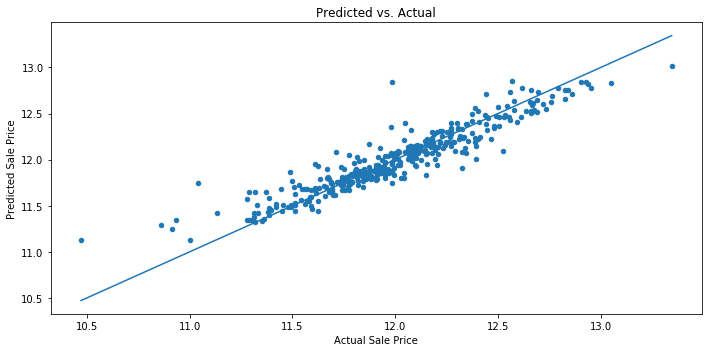

In [119]:
X_train,X_test,y_train,y_test = train_test_split(trainX,trainY)

clf = RandomForestRegressor(n_estimators=500)
clf.fit(X_train,y_train)
yPred = clf.predict(X_test)

plt.figure(figsize=(10, 5))
plt.scatter(y_test, yPred, s=20)
plt.title('Predicted vs. Actual')
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')

plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)])
plt.tight_layout()

In [120]:
yPred.shape

(365,)

In [121]:
clf.score(X_test,y_test)

0.86951923445723522